# Damage Assessment from image during natural disasters

Initial notebook to reproduce the results of the paper and try other models that could provide better performance.We wrote and experiment script and manually  try several experiments with VGG16 and EfficientNet.The final experiment module will be automated and reproducable in another script. 

For the AWS disaster response hackathon one of the challenge is to answer the question : **HOW MIGHT WE ACCURATELY AND EFFICIENTLY DETERMINE THE EXTENT OF DAMAGE TO INDIVIDUAL HOMES IN A GIVEN DISASTER-IMPACTED AREA ?**

To answer that question our team proposed to build and deploy an edge-based computer vision solution on smartphones for damage assessment.

In [1]:
#!pip install pandas
#!pip install tensorflow
#!pip install tensorflow_addons
#!pip install matplotlib


     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [2]:
import os
import re
import pandas as pd
import numpy as np
import gc

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks,models,layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [3]:
print(tf.__version__)

2.6.0


## Download the data

Images collected from Twitter during four natural disasters, namely Typhoon Ruby (2014), Nepal Earthquake (2015), Ecuador Earthquake (2016), and Hurricane Matthew (2016). In addition to Twitter images, it contains images collected from Google using queries such as "damage building", "damage bridge", and "damage road" to deal with labeled data scarcity problem. The images are labeled in 3 classes:
* Severe
* Mild
* None

In [4]:
#!wget https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz

In [5]:
import os
#!os.makedirs("data",exist_ok=True)

In [5]:
#!tar -xvzf ASONAM17_Damage_Image_Dataset.tar.gz -C data

## Get data and convert image path and label to csv

In [6]:
import os
cwd = os.getcwd()
cwd

'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\notebooks'

In [7]:
cwd = 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\'

In [9]:
import csv
os.makedirs(f"{cwd}/data/damage_csv",exist_ok=True)
images_path = os.path.join(cwd,'data','ASONAM17_Damage_Image_Dataset')
damage_path = os.path.join(cwd,'data',"damage_csv")

print(images_path)
print(damage_path)

def _get_train_files_by_event(images_path,event_file):
    files =[]
    for f in os.listdir(images_path):
        if not f.startswith('.'):
            if f.startswith(event_file) and os.path.isfile(os.path.join(images_path,f)):
                path = os.path.join(images_path,f)
                files.append(path)
    return files


def _get_train_file_data(file_path):
    data_raw_file = []
    with open(file_path,mode='r',encoding='utf-8') as f:
        for line in f.readlines():
            csvline = []
            image,label = line.split()
            csvline.append(image)
            csvline.append(int(label))
            data_raw_file.append(csvline)
    
    return data_raw_file



def _save_train_file_as_csv(event_file,data_raw_file,damage_path,file_path):
    os.makedirs(f"{damage_path}/{event_file}/",exist_ok=True)
    if file_path.endswith('.dev'):
        file_csv = 'dev.csv'
    elif file_path.endswith('.train'):
        file_csv = 'train.csv'
    elif file_path.endswith('.test'):
        file_csv = 'test.csv'
        
    with open(f"{damage_path}/{event_file}/{file_csv}",mode='w',encoding='utf-8') as f:
        writer = csv.writer(f)
        for row in data_raw_file:
            writer.writerow(row)
        f.close()
        
## Save as CSV all data for an event

def save_all_files(images_path,event_file):
    files = _get_train_files_by_event(images_path,event_file)
    print(files)
    for f in files:
        data_file = _get_train_file_data(f)
        _save_train_file_as_csv(event_file,data_file,damage_path,f) 

        

c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\ASONAM17_Damage_Image_Dataset
c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\damage_csv


In [9]:
save_all_files(images_path,'ecuador')
save_all_files(images_path,'nepal')
save_all_files(images_path,'matthew')
save_all_files(images_path,'ruby')
save_all_files(images_path,'gg')

['/content/data/ASONAM17_Damage_Image_Dataset/ecuador.test', '/content/data/ASONAM17_Damage_Image_Dataset/ecuador.train', '/content/data/ASONAM17_Damage_Image_Dataset/ecuador.dev']
['/content/data/ASONAM17_Damage_Image_Dataset/nepal.dev', '/content/data/ASONAM17_Damage_Image_Dataset/nepal.test', '/content/data/ASONAM17_Damage_Image_Dataset/nepal.train']
['/content/data/ASONAM17_Damage_Image_Dataset/matthew.train', '/content/data/ASONAM17_Damage_Image_Dataset/matthew.test', '/content/data/ASONAM17_Damage_Image_Dataset/matthew.dev']
['/content/data/ASONAM17_Damage_Image_Dataset/ruby.test', '/content/data/ASONAM17_Damage_Image_Dataset/ruby.dev', '/content/data/ASONAM17_Damage_Image_Dataset/ruby.train']
['/content/data/ASONAM17_Damage_Image_Dataset/gg.dev', '/content/data/ASONAM17_Damage_Image_Dataset/gg.train', '/content/data/ASONAM17_Damage_Image_Dataset/gg.test']


#### Create Cross-event datasets

In [10]:
!python cross-event-dataset.py

working dir /content
nepal : train.csv : 11463
nepal : dev.csv : 3821
nepal : test.csv : 3820
                                       path  label
0     nepal_eq/nepal_eq_severe_im_16084.jpg      2
1       nepal_eq/nepal_eq_none_im_42600.jpg      0
2        nepal_eq/nepal_eq_none_im_4536.jpg      0
3     nepal_eq/nepal_eq_severe_im_41412.jpg      2
4       nepal_eq/nepal_eq_none_im_31122.jpg      0
...                                     ...    ...
3815    nepal_eq/nepal_eq_none_im_29243.jpg      0
3816  nepal_eq/nepal_eq_severe_im_26541.jpg      2
3817    nepal_eq/nepal_eq_none_im_33094.jpg      0
3818    nepal_eq/nepal_eq_none_im_12777.jpg      0
3819     nepal_eq/nepal_eq_mild_im_9601.jpg      1

[19104 rows x 2 columns]
nepal:19104
gg : train.csv : 1804
gg : dev.csv : 602
gg : test.csv : 601
                                                 path  label
0    ggImage/building_damage/building_damage_3025.jpg      2
1            ggImage/road_damage/road_damage_2240.jpg      2
2           

## Load data in a Tensorflow Dataset

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math

IMG_SIZE = 224
batch_size = 32
num_classes = 3

data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

def get_sample():
    pass
    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100,frac=0.1,seed=42):


    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']
    train_df = train_df.sample(frac=frac,random_state=seed)

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']
    valid_df = valid_df.sample(frac=frac,random_state=seed)

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']
    test_df = test_df.sample(frac=frac,random_state=seed)

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,           
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
           
        
    steps_per_epoch = compute_steps_per_epoch(len(train_df)) 
    validation_steps = compute_steps_per_epoch(len(valid_df))
    
    print(f"steps_per_epochs: { steps_per_epoch}")
    print(f"validations_steps: { validation_steps}")
    
    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps
    
            



    

In [11]:

train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'cross_event_ecuador',
                                    is_augment=False,batch_size=32,buffer_size=100,frac=0.2)
    

Found 4422 validated image filenames.
Found 228 validated image filenames.
Found 228 validated image filenames.
steps_per_epochs: 139
validations_steps: 8


In [12]:
class_names=['none','mild','severe']

## Visualize data

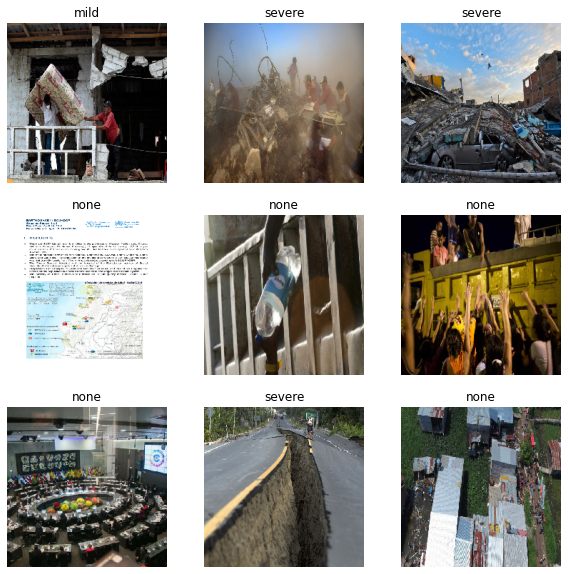

In [13]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

In [14]:
def subplot_learning_curve(model_name,history):
    #plt.clf()
    plt.figure(figsize=(10,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(model_name + ": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

## Create EfficientNet Architecture

In [15]:
from keras.applications.efficientnet import EfficientNetB0

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB0(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

get_efficient_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
___________________________

## Create Experiment

In [17]:
def finetune_model(lr,model_name,train_batches,valid_batches,initial_epoch,
                   epochs, steps_per_epoch,validation_steps,use_clr=False,init_lr=1e-3,max_lr=1e-2,model=None):
    print(f"finetuning lr ={lr}")
    print(f"finetuning epochs ={epochs}")
    print(f"init LR epochs ={init_lr}")
    print(f"max LR epochs ={max_lr}")
    
    if use_clr:
        print("using cyclical LR for finetuning")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr      

    
    if model:
        for layer in model.layers:
            layer.trainable = True
        
        check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
        early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

        model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['acc'])

        print()
        print("Training..................")
        history = model.fit(train_batches,
                        initial_epoch=initial_epoch,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_batches,
                        validation_steps = validation_steps,
                        callbacks=[check,early_stop])
        
        print()
        print('loading best weights model')
        model = models.load_model(f'./model/{model_name}.h5')
       
    return history, model

      
    
    

In [19]:

def run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=32,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=20,init_lr=1e-3,max_lr=1e-2,frac=0.1):
    
    print(f"******************{exp_name}*********************************")
    print(f"model_name ={model_name}")
    print(f"data augmentation ={is_augment}")
    print(f"event ={event}")
    print(f"finetuning ={do_finetune}")
    print(f"lr ={lr}")
    print()
    
    gc.collect()

    print(f"Creating dataset.....")
    train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps = create_dataset(damage_path,
                                                                                               event,
                                                                                  is_augment=is_augment,
                                                                                  batch_size= batch_size,frac=frac)
    
    if use_clr:
        print("using cyclical LR for training")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr
   

    print("Model architecture...........")
    if model_name == 'vgg16':
        model = get_vgg16_model(lr=lr)
    if model_name == 'vgg16_fc2':
        model = get_vgg16_fc2_model(lr=lr)
    elif model_name =='efficientnet':
        model = get_efficient_model(lr=lr) 
    elif model_name =='mobilenet':
        model = get_mobilenet_model(lr=lr)

    check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
    early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

    print()
    print("Training..................")
    history = model.fit(train_batches,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_batches,
                validation_steps = validation_steps,
                callbacks=[check,early_stop])
    
    
    print()
    subplot_learning_curve(model_name,history)
    
    print()
    print('loading best weights model')
    #model = models.load_model(f'./model/{model_name}.h5')

    print()
    print(f"Run evaluation.........")   
  
    results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
    results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)

    print()
    print(f"Training accuracy: {results_train['acc']}")
    print(f"Validation accuracy: {results_test['acc']}")
    
    if do_finetune:
        
        if not use_clr:
            #LR finetuning when not using CLR
            lr = lr * 1e-2
        print()
        print(f"******Fine tuning***********************")
        history, model = finetune_model(lr=lr,model_name=model_name,train_batches=train_batches,
                                        valid_batches=valid_batches, initial_epoch=n_epochs,epochs=2*n_epochs,
                                        steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,
                                        use_clr=use_clr,init_lr=init_lr * 1e-2,max_lr=max_lr * 1e-2,model=model)
        print()
        subplot_learning_curve(model_name+"_fintuned",history)
        
        results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
        results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)
        
        print()
        print(f"Training finetune accuracy: {results_train['acc']}")
        print(f"Validation finetune accuracy: {results_test['acc']}")
        

    return results_train['acc'],results_test['acc'],model,train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps

## Running Training experiments

### EfficientNet no augmentation

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =cross_event_ecuador
finetuning =False
lr =0.005

Creating dataset.....


C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 6633 validated image filenames.
Found 342 validated image filenames.
Found 342 validated image filenames.
steps_per_epochs: 208
validations_steps: 11
Model architecture...........
lr in model = 0.005
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_____________________________________________________

C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


208/208 [==============================] - 347s 2s/step - loss: 0.6340 - acc: 0.7577 - val_loss: 0.5011 - val_acc: 0.8421
Epoch 2/3
208/208 [==============================] - 299s 1s/step - loss: 0.5568 - acc: 0.7978 - val_loss: 0.6465 - val_acc: 0.7749
Epoch 3/3
208/208 [==============================] - 291s 1s/step - loss: 0.5390 - acc: 0.7999 - val_loss: 0.5922 - val_acc: 0.7865



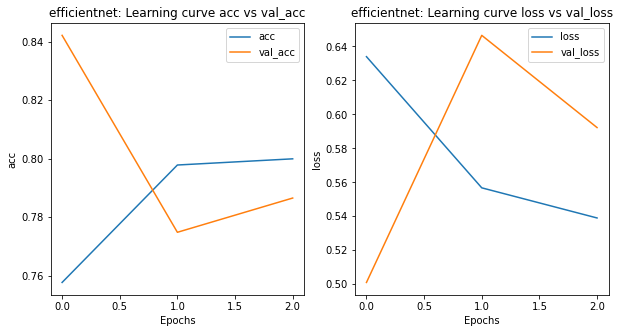


loading best weights model

Run evaluation.........
11/11 [==============================] - 12s 1s/step - loss: 0.5922 - acc: 0.7865

Training accuracy: 0.8382330536842346
Validation accuracy: 0.7865496873855591
Wall time: 20min 33s


In [287]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'cross_event_ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=5 * 1e-3,batch_size=32,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=3,init_lr=1e-3,max_lr=1e-2,frac=0.3)

## Prediction

In [279]:
rs1,rs2, model,train_ds,valid_ds,test_ds,steps_per_epoch,validation_steps = rs
print(rs1,rs2)

0.8805969953536987 0.7719298005104065


In [280]:
results_train = model.evaluate(train_ds, steps=steps_per_epoch, return_dict=True)
results_train

70/70 [==============================] - 102s 1s/step - loss: 0.3376 - acc: 0.8752


{'loss': 0.3376116156578064, 'acc': 0.8751696348190308}

In [281]:
results_valid = model.evaluate(valid_ds, steps=validation_steps, return_dict=True)
results_valid

4/4 [==============================] - 5s 1s/step - loss: 0.5140 - acc: 0.7719


{'loss': 0.5139932036399841, 'acc': 0.7719298005104065}

In [282]:
results_test = model.evaluate(test_ds, steps=validation_steps,return_dict=True)
results_test

4/4 [==============================] - 6s 1s/step - loss: 0.4232 - acc: 0.8596


{'loss': 0.4232430160045624, 'acc': 0.859649121761322}

In [288]:
# transform dataset to numpy
# loop through dataset and predict by batch
# check predict generator use case from udemy course

In [289]:
%%time
def batch_predict(ds,model,validation_steps):
    
    y_true = np.concatenate([y for x,y in ds.take(validation_steps)])
    preds = np.concatenate([model.predict(image_batch) for image_batch,label in ds.take(validation_steps)])
    print(accuracy_score(y_true,np.argmax(preds,axis=-1)))
    preds_labels = np.argmax(preds,axis=-1)
   
    results = pd.DataFrame({'y_true':y_true,
                            'y_pred':preds_labels})
    
    return results



Wall time: 0 ns


In [290]:
import numpy as np

y_true = np.concatenate([y for x,y in test_ds.take(validation_steps)])
preds = np.concatenate([model.predict(image_batch) for image_batch,label in test_ds.take(validation_steps)])
print(accuracy_score(y_true,np.argmax(preds,axis=-1)))

results = batch_predict(test_ds,model,validation_steps)
model.evaluate(test_ds,steps=validation_steps,return_dict=True)

0.8596491228070176
0.8596491228070176
4/4 [==============================] - 5s 1s/step - loss: 0.4232 - acc: 0.8596


{'loss': 0.4232430160045624, 'acc': 0.859649121761322}

In [291]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score
import pandas as pd

def compute_metrics(pred):
    labels = pred.y_true
    preds = pred.y_pred
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels,preds,average='weighted',zero_division=0)
    recall = recall_score(labels,preds,average='weighted',zero_division=0)
    f1 = f1_score(labels,preds,average='weighted',zero_division=0)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

compute_metrics(results)

{'accuracy': 0.8596491228070176,
 'f1': 0.851769253642581,
 'precision': 0.8441520467836258,
 'recall': 0.8596491228070176}

In [286]:
from sklearn.metrics import classification_report
print(classification_report(results.y_true, results.y_pred, target_names=class_names,zero_division=0,output_dict=False))

              precision    recall  f1-score   support

        none       0.88      0.88      0.88        51
        mild       0.00      0.00      0.00         5
      severe       0.88      0.91      0.90        58

    accuracy                           0.86       114
   macro avg       0.59      0.60      0.59       114
weighted avg       0.84      0.86      0.85       114



In [ ]:
from sklearn.metrics import classification_report
classes_report = classification_report(results.y_true, results.y_pred, target_names=class_names,zero_division=0,output_dict=True)

In [ ]:
classes_report

{'accuracy': 0.4678362573099415,
 'macro avg': {'f1-score': 0.3450108077181107,
  'precision': 0.34876905997975644,
  'recall': 0.3451300665456745,
  'support': 342},
 'mild': {'f1-score': 0.06451612903225808,
  'precision': 0.08333333333333333,
  'recall': 0.05263157894736842,
  'support': 19},
 'none': {'f1-score': 0.45307443365695793,
  'precision': 0.4268292682926829,
  'recall': 0.4827586206896552,
  'support': 145},
 'severe': {'f1-score': 0.5174418604651163,
  'precision': 0.536144578313253,
  'recall': 0.5,
  'support': 178},
 'weighted avg': {'f1-score': 0.46498903653410095,
  'precision': 0.4646412636711444,
  'recall': 0.4678362573099415,
  'support': 342}}

{'accuracy': 0.4678362573099415,
 'macro avg': {'f1-score': 0.3450108077181107,
  'precision': 0.34876905997975644,
  'recall': 0.3451300665456745,
  'support': 342},
 'mild': {'f1-score': 0.06451612903225808,
  'precision': 0.08333333333333333,
  'recall': 0.05263157894736842,
  'support': 19},
 'none': {'f1-score': 0.45307443365695793,
  'precision': 0.4268292682926829,
  'recall': 0.4827586206896552,
  'support': 145},
 'severe': {'f1-score': 0.5174418604651163,
  'precision': 0.536144578313253,
  'recall': 0.5,
  'support': 178},
 'weighted avg': {'f1-score': 0.46498903653410095,
  'precision': 0.4646412636711444,
  'recall': 0.4678362573099415,
  'support': 342}}